In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

file_path = r"C:\Users\kimge\OneDrive\문서\Desktop\김 건\가천대학교\2025년 4학년 1학기_시간표\인공지능개론\6_week\diabetes\diabetes.csv"
df = pd.read_csv(file_path)

In [5]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [7]:
df['Outcome'].value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

<Axes: ylabel='count'>

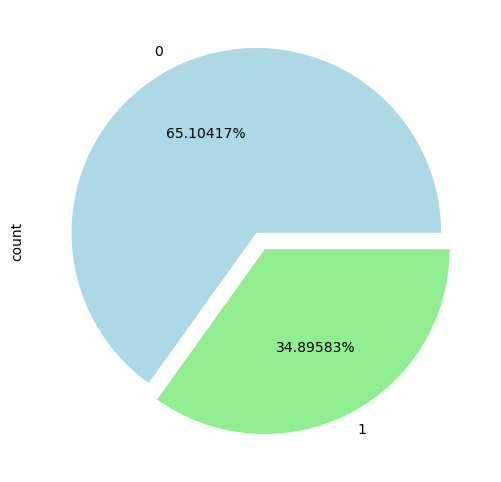

In [11]:
import matplotlib.pyplot as plt
from torchsummary import summary
import numpy as np

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 8
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size
df['Outcome'].value_counts().plot(kind='pie', autopct='%0.05f%%', colors=['lightblue', 'lightgreen', 'orange', 'pink'], explode=(0.05, 0.05))

In [13]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [15]:
df.dtypes

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

In [18]:
X = df.drop('Outcome', axis=1).values
y = df['Outcome'].values

In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler() # Standardize the data
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [24]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((614, 8), (154, 8), (614,), (154,))

In [27]:
# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.int64)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.int64)

In [30]:
# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [33]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([614, 8]),
 torch.Size([154, 8]),
 torch.Size([614]),
 torch.Size([154]))

In [74]:
class DiabetesDense(nn.Module):
    def __init__(self):
        super(DiabetesDense, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(8, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.model(x)

In [76]:
model = DiabetesDense()

In [78]:
criterion = nn.BCELoss() # 모델의 sigmoid 함수가 있을 경우
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [84]:
train_losses = []
test_accuracies = []

# 반복 학습
num_epochs = 25
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for inputs, labels in train_dataloader:
        labels = labels.float().unsqueeze(1)  # ✅ 레이블 차원 맞추기
        optimizer.zero_grad()
        outputs = model(inputs)  # sigmoid가 모델에 이미 포함되어 있음
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses.append(running_loss / len(train_dataloader))

    # 평가
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            labels = labels.float().unsqueeze(1)
            outputs = model(inputs)  # ✅ sigmoid 이미 적용됨
            predicted = (outputs >= 0.5).float()  # 다시 sigmoid X

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_losses[-1]:.4f}, Accuracy: {accuracy:.2f}%")

print("Training complete.")

Epoch 1/25, Loss: 0.4690, Accuracy: 80.52%
Epoch 2/25, Loss: 0.4856, Accuracy: 79.22%
Epoch 3/25, Loss: 0.4565, Accuracy: 81.17%
Epoch 4/25, Loss: 0.4385, Accuracy: 81.17%
Epoch 5/25, Loss: 0.4265, Accuracy: 80.52%
Epoch 6/25, Loss: 0.4323, Accuracy: 78.57%
Epoch 7/25, Loss: 0.4114, Accuracy: 79.22%
Epoch 8/25, Loss: 0.4099, Accuracy: 78.57%
Epoch 9/25, Loss: 0.4169, Accuracy: 80.52%
Epoch 10/25, Loss: 0.4035, Accuracy: 78.57%
Epoch 11/25, Loss: 0.3815, Accuracy: 79.22%
Epoch 12/25, Loss: 0.3733, Accuracy: 79.22%
Epoch 13/25, Loss: 0.3782, Accuracy: 78.57%
Epoch 14/25, Loss: 0.3613, Accuracy: 79.87%
Epoch 15/25, Loss: 0.3628, Accuracy: 80.52%
Epoch 16/25, Loss: 0.3411, Accuracy: 77.27%
Epoch 17/25, Loss: 0.3340, Accuracy: 79.22%
Epoch 18/25, Loss: 0.3323, Accuracy: 77.27%
Epoch 19/25, Loss: 0.3197, Accuracy: 77.92%
Epoch 20/25, Loss: 0.3288, Accuracy: 77.92%
Epoch 21/25, Loss: 0.2948, Accuracy: 79.87%
Epoch 22/25, Loss: 0.3149, Accuracy: 77.92%
Epoch 23/25, Loss: 0.2903, Accuracy: 76.6

In [90]:
# 평가 모드
model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for inputs, labels in test_dataloader:
        outputs = model(inputs)
        predicted = (outputs >= 0.5).float()

        # 평가를 위해 int로 변환
        all_labels.extend(labels.cpu().int().numpy())
        all_predictions.extend(predicted.cpu().int().numpy().reshape(-1))

# numpy 배열로 변환
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# 혼동 행렬
conf_matrix = confusion_matrix(all_labels, all_predictions)

# 정밀도, 재현율, F1 점수
precision = precision_score(all_labels, all_predictions, average='weighted', zero_division=0)
recall = recall_score(all_labels, all_predictions, average='weighted', zero_division=0)
f1 = f1_score(all_labels, all_predictions, average='weighted', zero_division=0)

# Specificity 계산
specificity = []
for i in range(conf_matrix.shape[0]):
    tn = conf_matrix.sum() - (conf_matrix[i, :].sum() + conf_matrix[:, i].sum() - conf_matrix[i, i])
    fp = conf_matrix[:, i].sum() - conf_matrix[i, i]
    specificity.append(tn / (tn + fp + 1e-6))  # 0 나눗셈 방지

# 결과 출력
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'F1 Score: {f1:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Specificity: {np.mean(specificity):.2f}')

Confusion Matrix:
[[89 18]
 [16 31]]
F1 Score: 0.78
Precision: 0.78
Recall: 0.78
Specificity: 0.75


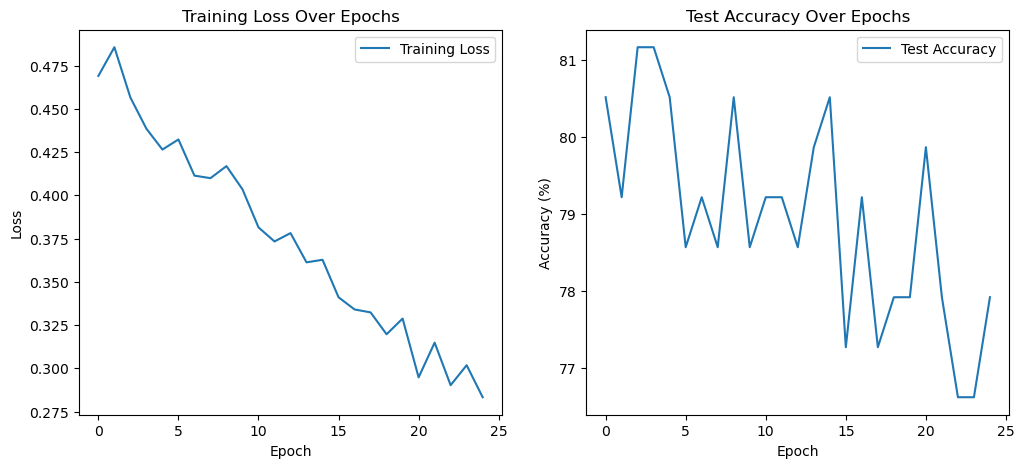

In [96]:
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Over Epochs')
plt.legend()

plt.show()